# Imports + Setup

In [47]:
import os, re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [63]:
# Set seeds for reproducibility
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior for CUDA
torch.backends.cudnn.benchmark = False      # Disable auto-tuner that can introduce randomness

In [64]:
# File Mapping
h_map = {2: 0.0375, 3: 0.084, 6: 0.1575}
flux_map = {88: 25900, 78: 21250, 73: 19400}
abs_map = {0: 3, 92: 100}
surf_map = {0: 0.98, 1: 0.76}
pattern = r"h(\d+)_flux(\d+)_abs(\d+).*?_surf(\d+).*?_(\d+)s"
# Depending on where u store the data files
# cd drive/MyDrive/Colab\ Notebooks/Theoretical_VTDP
DATA_DIR = "../../data/Theoretical_VTDP"
DROP_COLS = ["TC_9_5", "TC_Bottom_rec_groove", "TC_wall_ins_ext", "TC_bottom_ins_groove", "Theoretical_Temps_11"]

# Utilities

In [65]:
def parse_filename_params(filename):
    match = re.search(pattern, filename)
    if not match:
        return None
    h = h_map.get(int(match[1]))
    flux = flux_map.get(int(match[2]))
    abs_val = abs_map.get(int(match[3]))
    surf = surf_map.get(int(match[4]))
    min_time = int(match[5])
    return h, flux, abs_val, surf, min_time

def load_and_process_file(path, h, flux, abs_val, surf, min_time):
    df = pd.read_csv(path, encoding="utf-8-sig")
    df = df[df["Time"] >= min_time].copy()
    df.drop(columns=[col for col in df.columns if col in DROP_COLS or col.startswith("Depth_")], inplace=True)
    df["h"] = h
    df["flux"] = flux
    df["abs"] = abs_val
    df["surf"] = surf
    return df

# Load and Combine Data

In [66]:
dataframes = []
for fname in os.listdir(DATA_DIR):
    if not fname.endswith(".csv"):
        continue
    params = parse_filename_params(fname)
    if params is None or None in params:
        print(f"Skipping: {fname}")
        continue
    path = os.path.join(DATA_DIR, fname)
    df = load_and_process_file(path, *params)
    dataframes.append(df)

data = pd.concat(dataframes, ignore_index=True)

Skipping: h2_flux88_abs25_newSalt_surf0_172s - Sheet1_processed.csv
Skipping: h2_flux88_abs25_newSalt_wr_surf0_123s - Sheet1_processed.csv
Skipping: h2_flux88_abs25_surf0_493s - Sheet1_processed.csv
Skipping: h2_flux88_abs25_wr_surf0_393s - Sheet1_processed.csv
Skipping: h2_flux88_abs25_wr_surfParAdded_169s - Sheet1_processed.csv
Skipping: h2_flux88_abs25_wr_surfSimD_525s - Sheet1_processed.csv
Skipping: h3_flux88_abs25_mr_surf0_796s-Sheet1_processed.csv
Skipping: h3_flux88_abs25_surf0_439s-Sheet2_processed.csv
Skipping: h3_flux88_abs25_surf0_660s-Sheet1_processed.csv
Skipping: h3_flux88_abs25_wr_surf0_422s-Sheet1_processed.csv
Skipping: h3_flux88_abs25_wr_surf0_746s-Sheet2_processed.csv
Skipping: h3_flux88_abs90_mr_surf0_506s-Sheet1_processed.csv
Skipping: h3_flux88_abs90_surf0_692s-Sheet2_processed.csv
Skipping: h3_flux88_abs90_surf0_747s-Sheet3_processed.csv
Skipping: h3_flux88_abs90_surf0_749s-Sheet1_processed.csv
Skipping: h3_flux88_abs90_surf0_Redone_640s-Sheet3_processed.csv
Ski

# Preprocessing

In [67]:
# 4. PREPROCESSING
theory_cols = sorted([c for c in data.columns if c.startswith("Theoretical_Temps_")])
X = data[["Time", "h", "flux", "abs", "surf"] + theory_cols]
y = data.drop(columns=["Time", "h", "flux", "abs", "surf"] + theory_cols)
y_columns = y.columns

X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X = X_scaler.fit_transform(X)
y = y_scaler.fit_transform(y)

In [68]:
theory_cols = [c for c in data.columns if c.startswith("Theoretical_Temps_")]
X = data[["Time", "h", "flux", "abs", "surf"] + theory_cols]
y = data.drop(columns=["Time", "h", "flux", "abs", "surf"] + theory_cols)

X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=1)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Model

In [69]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return self.fc4(x)

input_size = X_train.shape[1]
output_size = y_train.shape[1]
model = NeuralNet(input_size, output_size)

# Training

In [79]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 500

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train)
    loss = criterion(predictions, y_train)
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_preds = model(X_test)
        val_loss = criterion(val_preds, y_test)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.6f}")

Epoch [50/500], Loss: 0.011575
Epoch [100/500], Loss: 0.011556
Epoch [150/500], Loss: 0.011548
Epoch [200/500], Loss: 0.011540
Epoch [250/500], Loss: 0.011532
Epoch [300/500], Loss: 0.011523
Epoch [350/500], Loss: 0.011515
Epoch [400/500], Loss: 0.011506
Epoch [450/500], Loss: 0.011496
Epoch [500/500], Loss: 0.011487


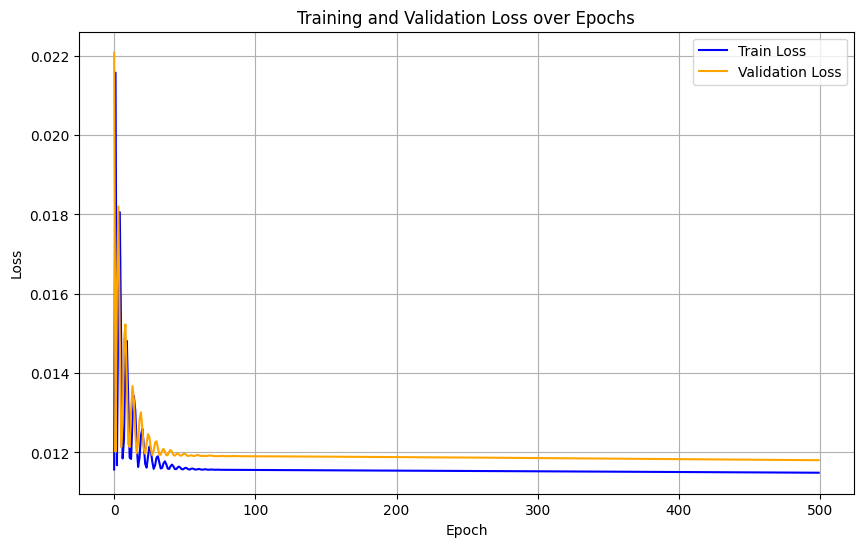

In [80]:
# ✅ Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation

In [81]:
model.eval()
with torch.no_grad():
    preds = model(X_test).numpy()

preds_real = y_scaler.inverse_transform(preds)
y_real = y_scaler.inverse_transform(y_test.numpy())
rmse = np.sqrt(np.mean((preds_real - y_real) ** 2, axis=0))

print("\nRMSE per output (°C):")
for col, val in zip(y.columns, rmse):
    print(f"{col}: {val:.3f} °C")

print(f"\nAverage RMSE across all outputs: {np.mean(rmse):.3f} °C")

torch.save(model.state_dict(), "thermal_model_weights.pth")
print("Model weights saved to 'thermal_model_weights.pth'")


RMSE per output (°C):
TC1_tip: 40.109 °C
TC2: 39.686 °C
TC3: 40.154 °C
TC4: 39.476 °C
TC5: 39.243 °C
TC6: 38.763 °C
TC7: 38.992 °C
TC8: 39.512 °C
TC9: 40.437 °C
TC10: 41.180 °C

Average RMSE across all outputs: 39.755 °C
Model weights saved to 'thermal_model_weights.pth'


<!-- ----------------------------------------------------------------------------------------------------------------------------------- -->

In [82]:
new_input = [
    [  # Full input vector for inference
        1049.0,     # Time (seconds)
        0.1575,     # Depth (h)
        25900,      # Heat flux (q0)
        3,          # Absorption coefficient (abs)
        0.98        # Surface emissivity (surf)
    ] + [350.0]*10  # Theoretical temperature values at 10 vertical points
]
new_input_scaled = X_scaler.transform(new_input)
new_tensor = torch.tensor(new_input_scaled, dtype=torch.float32)

with torch.no_grad():
    pred = model(new_tensor).numpy()
real_pred = y_scaler.inverse_transform(pred)
print("\nPredicted Temperatures:", real_pred)



Predicted Temperatures: [[351.22638 351.75836 352.0165  352.22012 353.41782 356.8542  359.52322
  362.5966  359.9102  348.00497]]


C:\Users\Rajasekar\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
